In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No CUDA device available")
print(f"Using {device} device")

NVIDIA GeForce RTX 3050 Laptop GPU
Using cuda device


## **Model Definition**

In [3]:
class CANN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=1):
        super(CANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, strain_tensor):
        return self.net(strain_tensor)

## **Data Preparation**

The Neo-Hookean strain energy function for a 3D-compressible material is defined below:

$$ U = \frac{\mu}{2} (I_{1} - 3) + \frac{\kappa}{2}(J - 1) $$

$\mu$: shear modulus

$\kappa$: bulk modulus

$I_{1}$: first invariant of the isochoric (volume-preserving) part of the right Cauchy-Green tensor

$J$: det(F): Jacobian determinant of the deformation gradient

For incompressible materials, J = 1. Therefore, the equation reduces to

$$ U = \frac{\mu}{2} (I_{1} - 3) $$

Here, $I_{1}$ evaluates to $ I_{1} = \lambda_{1}^2 + \lambda_{2}^2 + \lambda_{3}^2 $

where $\lambda_{1}$, $\lambda_{2}$ and $\lambda_{3}$ are the ratio of stretches in three different principal axes.

In this example, we will consider the case of uniaxial loading. This means, $\lambda_{1} = \lambda_{2}$ and $\lambda_{3} = \frac{1}{\lambda}$ as another constraint $ \lambda_{1}*\lambda_{2}*\lambda_{3} = 1$ is also satisfied.

Here, engineering strain is taken which evaluates to $(\lambda - 1)$ from this derivation:

$$ \frac{\Delta L}{L_{0}} = \frac{L - L_{0}}{L_{0}} = \lambda - 1 $$

$L$: Length after deformation, $L_{0}$: Original length

Stress used is as follows:

$$ \sigma = \mu(\lambda² - \lambda^{-1}) $$

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Material parameters
mu = 0.5    # MPa

In [7]:
# Generate stretch values (lambda)
lambdas = np.linspace(0.5, 2.0, 100)

# Compute stress and strain
stress = mu * (lambdas**2 - lambdas**-1)
strain = lambdas - 1    # Engineering strain

# Optional: compute strain energy density
U = 0.5 * mu * (lambdas**2 + 2 * lambdas**-1 - 3)

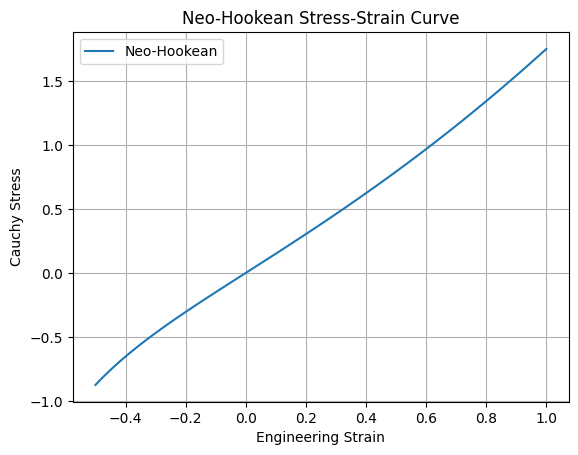

In [8]:
# Plot stress-strain curve
plt.plot(strain, stress, label='Neo-Hookean')
plt.xlabel('Engineering Strain')
plt.ylabel('Cauchy Stress')
plt.title('Neo-Hookean Stress-Strain Curve')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Convert the data to tensors
strain_data = torch.tensor(strain, dtype=torch.float32).reshape(-1, 1)
stress_data = torch.tensor(stress, dtype=torch.float32).reshape(-1, 1)

# Create a combined dataset
dataset = TensorDataset(strain_data, stress_data)

# Split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Ensure reproducibility
generator1 = torch.Generator().manual_seed(42)

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator1)

# Unpack the data
strain_data_train, stress_data_train = zip(*train_dataset)
strain_data_test, stress_data_test = zip(*test_dataset)

# Convert back to tensors
strain_data_train = torch.stack(strain_data_train)
stress_data_train = torch.stack(stress_data_train)
strain_data_test = torch.stack(strain_data_test)
stress_data_test = torch.stack(stress_data_test)

## **Model Implementation**

In [11]:
model = CANN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1000):

    model.train()
    pred = model(strain_data_train)
    loss = loss_fn(pred, stress_data_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.661544
Epoch 20: Loss = 0.176307
Epoch 40: Loss = 0.010146
Epoch 60: Loss = 0.005105
Epoch 80: Loss = 0.002705
Epoch 100: Loss = 0.002656
Epoch 120: Loss = 0.002538
Epoch 140: Loss = 0.002451
Epoch 160: Loss = 0.002369
Epoch 180: Loss = 0.002290
Epoch 200: Loss = 0.002213
Epoch 220: Loss = 0.002139
Epoch 240: Loss = 0.002070
Epoch 260: Loss = 0.002004
Epoch 280: Loss = 0.001941
Epoch 300: Loss = 0.001883
Epoch 320: Loss = 0.001829
Epoch 340: Loss = 0.001778
Epoch 360: Loss = 0.001730
Epoch 380: Loss = 0.001686
Epoch 400: Loss = 0.001644
Epoch 420: Loss = 0.001605
Epoch 440: Loss = 0.001568
Epoch 460: Loss = 0.001533
Epoch 480: Loss = 0.001499
Epoch 500: Loss = 0.001467
Epoch 520: Loss = 0.001437
Epoch 540: Loss = 0.001408
Epoch 560: Loss = 0.001380
Epoch 580: Loss = 0.001352
Epoch 600: Loss = 0.001326
Epoch 620: Loss = 0.001300
Epoch 640: Loss = 0.001274
Epoch 660: Loss = 0.001249
Epoch 680: Loss = 0.001225
Epoch 700: Loss = 0.001200
Epoch 720: Loss = 0.001177
Epoch 7

Test Loss: 0.001494


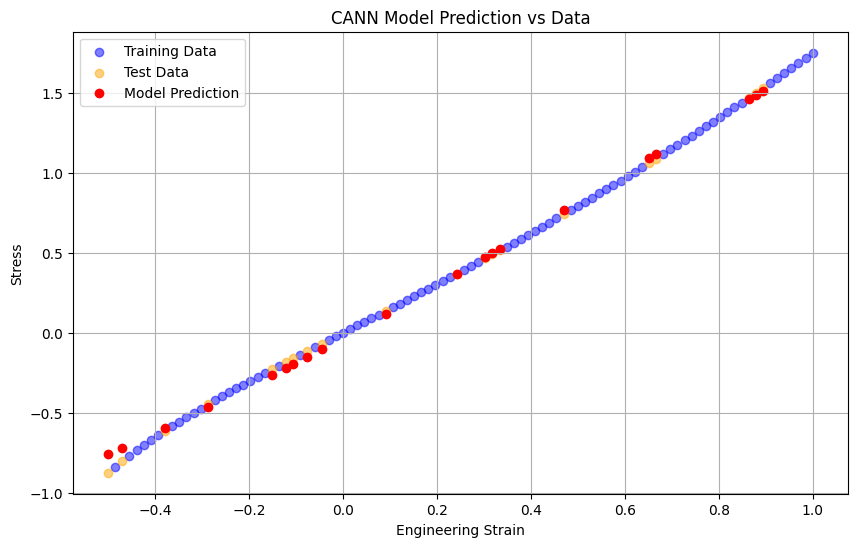

In [12]:
model.eval()
with torch.no_grad():
    pred_test = model(strain_data_test)
    test_loss = loss_fn(pred_test, stress_data_test)
    print(f"Test Loss: {test_loss.item():.6f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(strain_data_train.numpy(), stress_data_train.numpy(), label='Training Data', color='blue', alpha=0.5)
plt.scatter(strain_data_test.numpy(), stress_data_test.numpy(), label='Test Data', color='orange', alpha=0.5)
plt.scatter(strain_data_test.numpy(), pred_test.numpy(), label='Model Prediction', color='red')
plt.xlabel('Engineering Strain')
plt.ylabel('Stress')
plt.title('CANN Model Prediction vs Data')
plt.legend()
plt.grid(True)
plt.show()